# 7. 딥러닝을 위한 고급 도구

* 함수형 API 를 사용한 다양한 모델 : 다중입력, 다중 출력

* 만들어진(구현된) 모델 가져오기

* 구현된 모델 가져와서 더 쌓아가기

* 훈련 도중(.fit)에 훈련 과정을 조정하는 법

* 텐서보드 사용

* 실습 : 인물 사진에서 성별과 표정 맞추기

## 7.1  케라스의 함수형 API

### 7.1.1 함수형 API 소개

In [ ]:
x = layers.Input(shape=(100))
y = lyaers.Dense(1000, activation='relu')(x)
y = lyaers.Dense(10)(y)

### 7.1.2 다중 입력 모델

* 여러개의 인풋

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
def build_multi_input_model():
  x1 = layers.Input(shape=32, name='x1')
  y1 = layers.Dense(32, activation='relu')(x1)
  y1 = layers.Dense(16, activation='relu')(y1)

  x2 = layers.Input(shape=32, name='x2')
  y2 = layers.Dense(32, activation='relu')(x2)
  y2 = layers.Dense(16, activation='relu')(y2)

  # 두개의 브랜치를 하나로 합치기
  y = layers.concatenate([y1, y2])
  y = layers.Dense(10, activation='softmax', name='y')(y) # 10개 클래스
  return models.Model(inputs=[x1, x2], outputs=y)

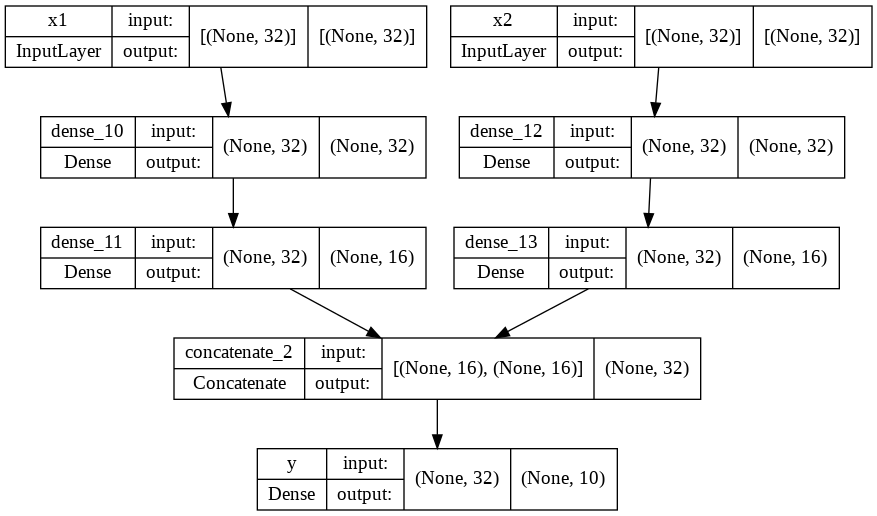

In [ ]:
model = build_multi_input_model()
#model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
import numpy as np
# 가짜 데이터 생성 (100개)
x1_train = np.random.random(size=(100, 32))
x2_train = np.random.random(size=(100, 32))
y_train = np.random.randint(0, 9, size=(100, )) # 0/ 1, ... /9 (sparse_crossentropy)사용한다 치면
print(y_train.shape)
for y in y_train[:5]:
  print(y)

(100,)
8
8
8
3
5


In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'rmsprop')

In [ ]:
model.fit([x1_train, x2_train], y_train, 
          epochs=5,
          batch_size=4)

Epoch 1/5
25/25 [==============================] - 1s 2ms/step - loss: 2.3323
Epoch 2/5
25/25 [==============================] - 0s 2ms/step - loss: 2.2341
Epoch 3/5
25/25 [==============================] - 0s 2ms/step - loss: 2.1788
Epoch 4/5
25/25 [==============================] - 0s 2ms/step - loss: 2.1409
Epoch 5/5
25/25 [==============================] - 0s 2ms/step - loss: 2.1061


In [ ]:
model.fit({'x1':x1_train, 'x2': x2_train}, y_train, 
          epochs=5,
          batch_size=4)

Epoch 1/5
25/25 [==============================] - 1s 2ms/step - loss: 2.3534
Epoch 2/5
25/25 [==============================] - 0s 1ms/step - loss: 2.2568
Epoch 3/5
25/25 [==============================] - 0s 2ms/step - loss: 2.2079
Epoch 4/5
25/25 [==============================] - 0s 2ms/step - loss: 2.1717
Epoch 5/5
25/25 [==============================] - 0s 2ms/step - loss: 2.1417


### 7.1.3 다중 출력 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
# 고객에 대한 정보(카드값, 보험료 ..)가 들어왔을 때 고객이 사는 지역, 성별, 나이 예측
def build_multi_output_model():
  x = layers.Input(shape=32, name='x')
  y = layers.Dense(32, activation='relu')(x)
  y = layers.Dense(16, activation='relu')(y)

  y_city = layers.Dense(10, activation='softmax', name='y_city')(y) # 10개 지역 (다중분류)
  y_gender = layers.Dense(1, activation='sigmoid', name='y_gender')(y) # 이진분류
  y_age = layers.Dense(1, name='y_age')(y)# 회귀
  return models.Model(inputs=x, outputs=[y_city, y_gender, y_age])

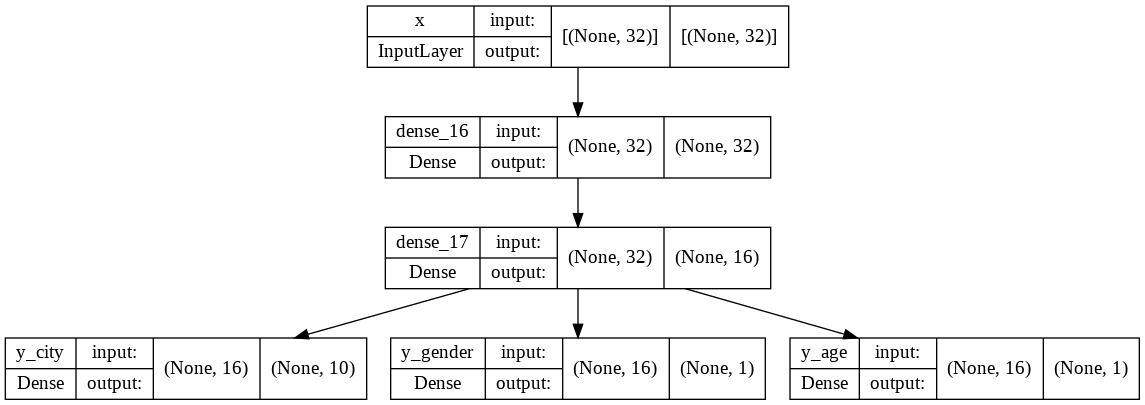

In [ ]:
model = build_multi_output_model()
utils.plot_model(model, show_shapes=True)

In [ ]:
# 가짜 데이터 만들기
x_train =
y1_train =
y2_train =
y3_train =


나이 회귀 작업에 사용되는 평균 제곱 오차(MSE) 손실은 일반적으로 3~5 사이의 값을 가집니다. 반면에 이진 분류 작업에 사용되는 크로스엔트로피 손실은 0.1 정도로 낮습니다. 이런 환경에서 서로 다른 손실에 균형을 맞추려면 크로스엔트로피 손실에 가중치 10을 주고 MSE 손실에 가중치 0.25를 줄 수 있습니다.

### 7.1.4 층으로 구성된 비순환 유향 그래프

함수형 API를 사용하면 다중 입력이나 다중 출력 모델뿐 아니라 내부 토폴로지가 복잡한 네트워크도 만들 수 있습니다. 케라스의 신경망은 층으로 구성된 어떤 비순환 유향 그래프도 만들수 있습니다. 

#### **인셉션 모듈**

인셉셥(inception)은 합성곱 신경망에서 인기 있는 네트워크 구조입니다. 일찍이 네트워크 안의 네트워크 구조에서 영감을 받아 2013~2014년에 크리스티안 세게디와 그의 구글 동료들이 만들었습니다.

> 1x1 합성곱의 목적

이미 알고 있듯이 합성곱은 입력 텐서에서 타일 주변의 패치를 추출하고 각 패치에 동일한 연산을 수행합니다. 이 경우는 추출된 패치가 하나의 타일로 이루어졌을 때입니다. 이 합성곱 연산은 모든 타일 벡터를 하나의 Dense 층에 통과시키는 것과 동일합니다. 즉 입력 텐서의 채널 정보를 혼합한 특성을 계산합니다. 공간 방향으로는 정보를 섞지 않습니다. 이런 11x1 합성곱은 인셉션 모듈의 특징입니다. 채널 방향의 특성 학습과 공간 방향의 특성 학습을 분리하는데 도움을 줍니다. 채널이 공간 방향으로 상관관계가 크고 채널 간에는 독립적이라고 가정하면 납득할 만한 전략입니다.

![](https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0207-01.PNG?raw=true)

#### **잔차 연결**

잔차연결(residual connection)은 엑셉션을 포함하여 2015년 이후 등장한 많은 네트워크 구조에 있는 그래프 형태의 네트워크 컴포넌트입니다. 2015년 후반 ILSVRC ImageNet경영 대회 우승 팀인 마이크로소프트의 허 등이 소개했습니다. 대규모 딥러닝 모델에서 흔히 나타나는 두가지 문제인 그래디언트 소실과 표현 병목을 해결했습니다.



### 7.1.5 층 가중치 공유

함수형 API의 중요한 또 하나의 기능은 층 객체를 여러번 재사용할 수 있다는 것입니다. 

### 7.1.6 층과 모델

함수형 API에서는 모델을 층처럼 사용할 수 있습니다. 모델을 하나의 '커다란 층'으로 생각해도 됩니다. 


### 7.1.7 추가 학습 : 인물 사진 분류하기

## 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

이 절에서 훈련하는 동안 모델 내부에서 일어나는 일을 조사하고 제어하는 방법을 살펴보겠습니다. 대규모 데이터셋에서 model.fit() 으로 수십번의 에포크를 실행하는 것은 종이 비행기를 날리는 것과 조금 비슷합니다. 일단 손을 떠나면 종이 비행기 경로와 착률 지점을 제어할 방법이 없습니다. 앞으로 소개할 기법은  model.fit() 호출할 때 종이 비행기가 아닌 스스로 판단하고 결정하는 똑똑한 자동 드론으로 바꾸어 줄 것입니다. 

### 7.2.1 콜백을 사용하여 모델의 훈련 과정 제어하기

다음은 콜백을 사용하는 몇 가지 사례입니다. 
* 모델 체크포인트 저장: 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장합니다.
* 조기종료 : 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지 합니다. (물론 훈련하는 동안 얻은 가장 좋은 모델을 저장합니다.)
* 훈련하는 동안 하이퍼 파라미터 값을 동적으로 조정합니다. : 옵티마이저의 학습률 같은 경우입니다. 
* 훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트 될때마다 시각화 합니다. 

```
tf.keras.callbacks.ModelCheckpoint
tf.keras.callbacks.EarlyStopping
tf.keras.callbacks.ReduceLROnPlateau
tf.keras.callbacks.CSVLogger
```


### 7.2.2 텐서보드 소개: 텐서플로의 시각화 프레임워크